In [82]:
#1. Setup and Initial Loading

import os, json
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from itertools import chain


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2


import random
SEED = 42

os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

na_like = {"", "na", "n/a", "none", "null", "nil", "nan", ".", "?", "-", "--"}

os.listdir('/content')

# Load the dataset
df = pd.read_csv("FedCycleData071012 (2).csv", na_values=list(na_like), skipinitialspace=True)

print(f"Initial data shape: {df.shape}")




Initial data shape: (1665, 80)


In [83]:
# 2. Data Cleaning and Type Correction

# Correct data types for key columns before processing
df['CycleNumber'] = pd.to_numeric(df['CycleNumber'], errors='coerce')

# coalesce paired columns
pair_fallbacks = [
    ('Age', 'AgeM'),
    ('Maristatus', 'MaristatusM'),
    ('Religion', 'ReligionM'),
    ('Ethnicity', 'EthnicityM'),
    ('Schoolyears', 'SchoolyearsM'),
    ('Medvits', 'MedvitsM'),
    ('Medvitexplain', 'MedvitexplainM'),
    ('Livingkids', 'LivingkidsM'),
    ('Nextpreg', 'NextpregM'),
    ('Spousesame', 'SpousesameM')
]

for primary, fallback in pair_fallbacks:
    if primary in df.columns and fallback in df.columns:
        df[primary] = df[primary].fillna(df[fallback])
        df.drop(columns=fallback, inplace=True)

print("Paired columns coalesced.")

# Sort for feature engineering
df = df.sort_values(['ClientID', 'CycleNumber']).reset_index(drop=True)

print(f"Data shape after sorting and coalescing: {df.shape}")

Paired columns coalesced.
Data shape after sorting and coalescing: (1665, 70)


In [84]:
# 3. Target Variable & Feature Engineering

# Define the Target Variable
df['LengthofCycle'] = pd.to_numeric(df['LengthofCycle'], errors='coerce')
df['next_cycle_length'] = df.groupby('ClientID')['LengthofCycle'].shift(-1)

# Drop rows where the target is missing
df_eng = df.dropna(subset=['next_cycle_length']).copy()

# Time-Series Features
for i in range(1, 4):
    df_eng[f'L{i}_LengthofCycle'] = df_eng.groupby('ClientID')['LengthofCycle'].shift(i)

lag_cols = ['L1_LengthofCycle', 'L2_LengthofCycle', 'L3_LengthofCycle']
df_eng['roll_mean_3_cycles'] = df_eng[lag_cols].mean(axis=1)
df_eng['roll_std_3_cycles'] = df_eng[lag_cols].std(axis=1)

# Advanced Time Series Features
df_eng['L1_L2_diff'] = df_eng['L1_LengthofCycle'] - df_eng['L2_LengthofCycle']
df_eng['L2_L3_diff'] = df_eng['L2_LengthofCycle'] - df_eng['L3_LengthofCycle']
df_eng['ewma_3_cycles'] = df_eng.groupby('ClientID')['LengthofCycle'].transform(
    lambda x: x.shift(1).ewm(span=3, adjust=False).mean()
)
df_eng['user_mean_cycle_length_so_far'] = df_eng.groupby('ClientID')['LengthofCycle'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df_eng['user_std_cycle_length_so_far'] = df_eng.groupby('ClientID')['LengthofCycle'].transform(
    lambda x: x.shift(1).expanding().std()
).fillna(0) # Fill NaNs for the first cycle
df_eng['user_cycle_count'] = df_eng.groupby('ClientID').cumcount()


# Text-Based Feature Engineering
if 'Gynosurgeries' in df_eng.columns:
    surg_text = df_eng['Gynosurgeries'].astype(str).str.lower()
    df_eng['had_c_section'] = surg_text.str.contains('c-section|c section|cesarean', regex=True).astype(float)
    df_eng['had_d_and_c'] = surg_text.str.contains('d&c|d & c|d and c', regex=True).astype(float)
    df_eng['had_laparoscopy'] = surg_text.str.contains('laparoscopy|laproscopy', regex=True).astype(float)

# Binary Flags
def is_yes_like(x):
    if pd.isna(x): return np.nan
    return 1.0 if str(x).strip().lower() in {'y', 'yes', 'true', 't', '1'} else 0.0

for col in ['CycleWithPeakorNot', 'IntercourseInFertileWindow', 'UnusualBleeding', 'Breastfeeding']:
    if col in df_eng.columns:
        df_eng[f'{col}_flag'] = df_eng[col].apply(is_yes_like)

# Correct data type for numerically-coded categoricals
cat_as_num_cols = ['Group', 'ReproductiveCategory', 'Maristatus', 'Religion', 'Ethnicity', 'Schoolyears', 'Reprocate', 'Method', 'Prevmethod', 'Whychart']
for col in cat_as_num_cols:
    if col in df_eng.columns:
        # Convert to string to ensure they are treated as categories
        df_eng[col] = pd.to_numeric(df_eng[col], errors='coerce').astype('Int64').astype(str).replace('<NA>', np.nan)

print(f"Data shape after feature engineering: {df_eng.shape}")


Data shape after feature engineering: (1506, 89)


In [85]:
# 4. Column Dropping

# Whitelist of columns to keep even if they have high missingness
WHITELIST = {
    'Age', 'BMI', 'Abortions', 'Miscarriages', 'Numberpreg', 'Livingkids',
    'Gynosurgeries', 'Urosurgeries', 'Medvits', 'Medvitexplain'
}

# Drop columns with > 90% missing data, unless whitelisted
missing_frac = df_eng.isna().mean()
print(missing_frac)
cols_to_drop_missing = missing_frac[(missing_frac > 0.9) & (~missing_frac.index.isin(WHITELIST))].index

# Also drop original flag/text columns and identifiers
cols_to_drop_other = [
    'CycleWithPeakorNot', 'IntercourseInFertileWindow', 'UnusualBleeding', 'Breastfeeding',
    'LengthofCycle', # Original target, now captured in lags
    'CycleNumber' # Identifier
]

all_cols_to_drop = list(cols_to_drop_missing) + [c for c in cols_to_drop_other if c in df_eng.columns]

df_clean = df_eng.drop(columns=all_cols_to_drop)

print(f"Dropped {len(all_cols_to_drop)} columns.")
print(f"Final data shape for EDA: {df_clean.shape}")

print(df_clean.isnull().sum())
df_clean.describe().T
print(df_clean.isnull().sum().sort_values(ascending=False).head(10))


ClientID                           0.000000
CycleNumber                        0.000000
Group                              0.000000
CycleWithPeakorNot                 0.000000
ReproductiveCategory               0.000000
                                     ...   
had_laparoscopy                    0.000000
CycleWithPeakorNot_flag            0.000000
IntercourseInFertileWindow_flag    0.000000
UnusualBleeding_flag               0.011952
Breastfeeding_flag                 0.912351
Length: 89, dtype: float64
Dropped 41 columns.
Final data shape for EDA: (1506, 49)
ClientID                              0
Group                                 0
ReproductiveCategory                  0
EstimatedDayofOvulation             128
LengthofLutealPhase                 128
FirstDayofHigh                      231
TotalNumberofHighDays                10
TotalHighPostPeak                     2
TotalNumberofPeakDays                12
TotalDaysofFertility                 27
TotalFertilityFormula           

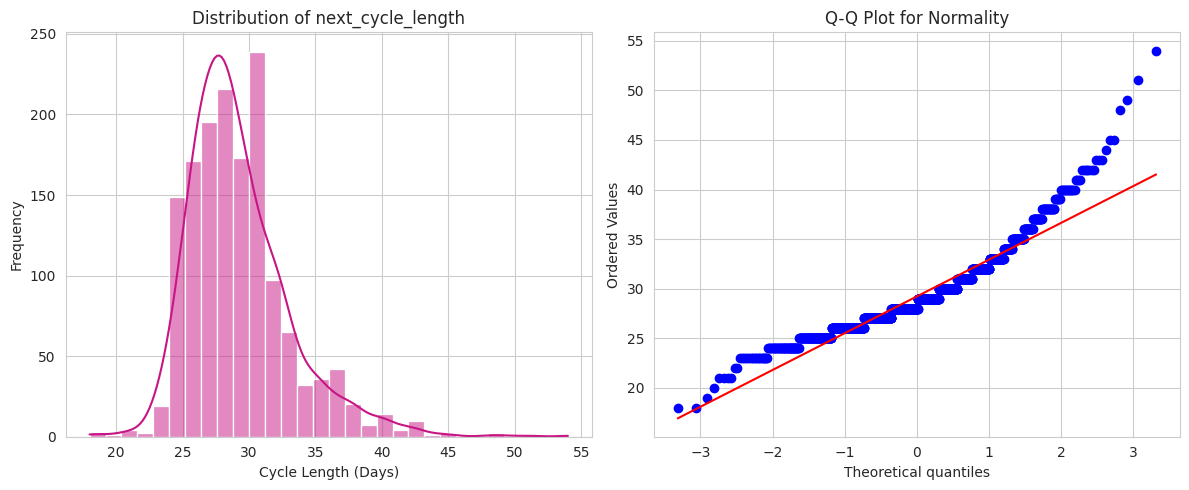

count    1506.000000
mean       29.221116
std         3.874902
min        18.000000
25%        27.000000
50%        28.000000
75%        31.000000
max        54.000000
Name: next_cycle_length, dtype: float64


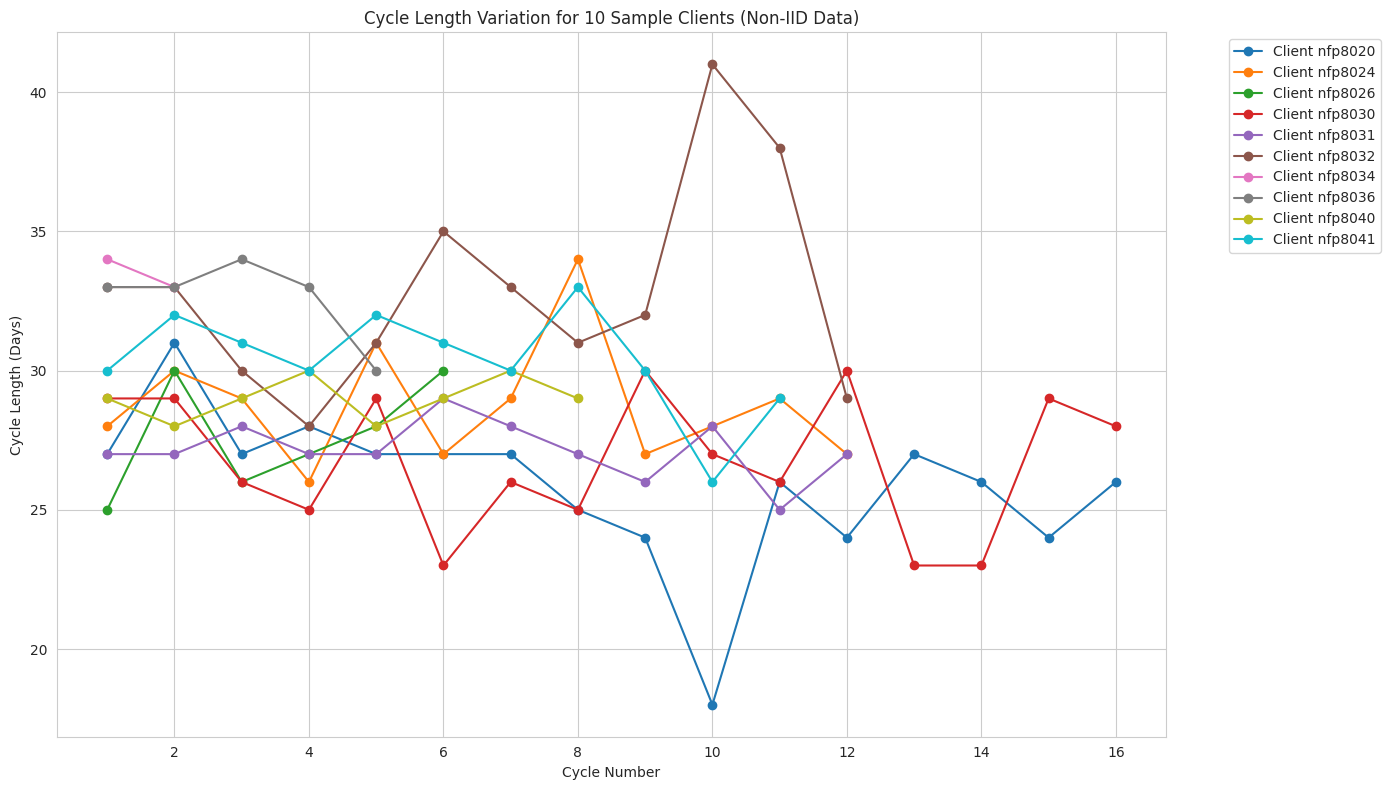

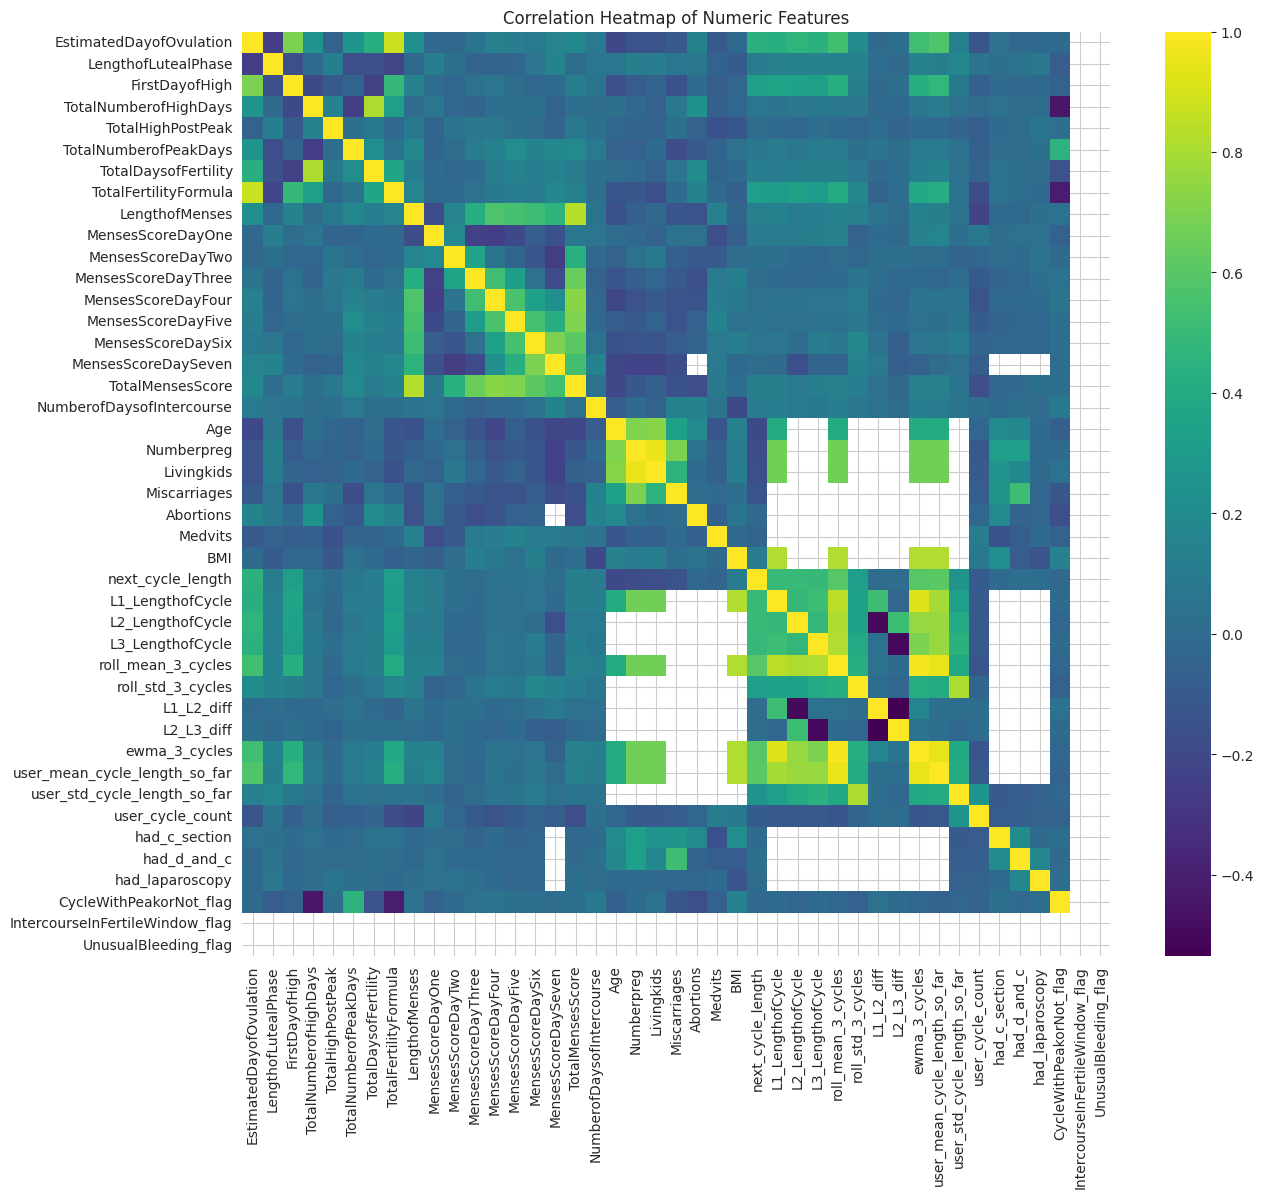

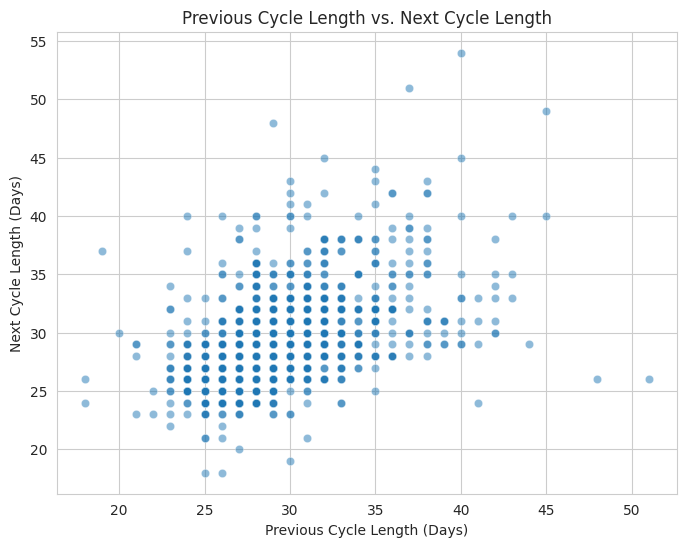

In [86]:
#  5. Exploratory Data Analysis

target = 'next_cycle_length'

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_clean[target], kde=True, bins=30, color='mediumvioletred')
plt.title(f'Distribution of {target}')
plt.xlabel('Cycle Length (Days)')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df_clean[target], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality')

plt.tight_layout()
plt.show()

print(df_clean[target].describe())



plt.figure(figsize=(14, 8))
sample_clients = df['ClientID'].unique()[:10]
for client in sample_clients:
    client_data = df[df['ClientID'] == client]
    plt.plot(client_data['CycleNumber'], client_data['LengthofCycle'], marker='o', linestyle='-', label=f'Client {client}')

plt.title('Cycle Length Variation for 10 Sample Clients (Non-IID Data)')
plt.xlabel('Cycle Number')
plt.ylabel('Cycle Length (Days)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Relationships

# Correlation Heatmap for Numeric Features
numeric_cols = df_clean.select_dtypes(include=np.number).columns
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='viridis', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Scatter plot of the strongest predictor vs. target
plt.figure(figsize=(8, 6))
sns.scatterplot(x='L1_LengthofCycle', y=target, data=df_clean, alpha=0.5)
plt.title('Previous Cycle Length vs. Next Cycle Length')
plt.xlabel('Previous Cycle Length (Days)')
plt.ylabel('Next Cycle Length (Days)')
plt.grid(True)
plt.show()



## Target Variable Distribution (Histogram & Q-Q Plot)
#### 1. What it Shows: This visualizes the distribution of the target variable, next_cycle_length. The histogram shows that most cycles are around 25-35 days long, with a "tail" of longer cycles. The Q-Q plot compares the data's distribution to a perfect normal (bell curve) distribution; a straight line indicates perfect normality.

#### 2. Why it Matters: The data is mostly normal but has outliers (the long cycles). This means standard regression models and metrics like RMSE/MAE are appropriate.

## Non-IID Data Visualization (Client-Level Analysis)
#### 1. What it Shows: This plot tracks the cycle length history for 10 individual users. Each line represents one person's menstrual history.

#### 2. Why it Matters: It clearly demonstrates that the data is non-IID (Not Independent and Identically Distributed). You can see that some users have very regular cycles (flat lines), while others are highly variable. A traditional centralized model tries to find a "one-size-fits-all" pattern, which might not work well for everyone. This plot provides the core justification for using federated learning, which can learn a model that adapts better to individual patterns.

## Feature Relationships (Heatmap & Scatter Plot)
#### 1. What they Show:

a. The heatmap shows the correlation between all the numeric features. Brighter colors mean a stronger positive correlation.

b. The scatter plot specifically visualizes the relationship between the previous cycle's length (L1_LengthofCycle) and the next cycle's length.

#### 2. Why they Matter: These plots confirm the strongest predictors. The heatmap shows that the lag features (L1, L2, L3) and rolling means are highly correlated with the target. The scatter plot drives this home, showing a clear positive trend: a longer previous cycle often implies a longer next cycle. This confirms that including cycle history was a powerful feature engineering step.

In [87]:
# 6. Final Preprocessing for Modeling
from sklearn.preprocessing import FunctionTransformer, RobustScaler

df_final = df_clean.copy()
target = 'next_cycle_length'

# Outlier handling
q_low  = df_final[target].quantile(0.01)
q_high = df_final[target].quantile(0.99)
df_final[target] = df_final[target].clip(lower=q_low, upper=q_high)

# Clip the lag features
for c in ['L1_LengthofCycle', 'L2_LengthofCycle', 'L3_LengthofCycle', 'roll_mean_3_cycles', 'roll_std_3_cycles']:
    if c in df_final:
        lo = df_final[c].quantile(0.01)
        hi = df_final[c].quantile(0.99)
        df_final[c] = df_final[c].clip(lo, hi)


# Define columns to exclude from the feature set
features_to_exclude = [target, 'ClientID']

# Get the list of all potential feature columns
all_features = [col for col in df_final.columns if col not in features_to_exclude]

# Now, separate them into types from this filtered list
numeric_features = [col for col in all_features if pd.api.types.is_numeric_dtype(df_final[col])]
categorical_features = [col for col in all_features if pd.api.types.is_object_dtype(df_final[col]) or pd.api.types.is_categorical_dtype(df_final[col])]
text_features = [col for col in ['Gynosurgeries', 'Urosurgeries', 'Medvitexplain'] if col in all_features]

# After you define text_features
if len(text_features) > 0:
    df_final['combined_text'] = df_final[text_features].fillna('').agg(' '.join, axis=1)
else:
    # Ensure the column exists even if there are no text features
    df_final['combined_text'] = ''

# Remove text features from other lists if they are present
categorical_features = [c for c in categorical_features if c not in text_features]

print(f"Identified {len(numeric_features)} numeric features.")
print(f"Identified {len(categorical_features)} categorical features.")
print(f"Identified {len(text_features)} text features for vectorization.")

# User-Level Train-Validation-Test Split (Leakage-Free)
client_ids = df_final['ClientID'].unique()

# Split
train_clients, temp_clients = train_test_split(client_ids, test_size=0.3, random_state=42)
val_clients, test_clients = train_test_split(temp_clients, test_size=0.5, random_state=42)

# Create dataframes based on the client ID splits
train_df = df_final[df_final['ClientID'].isin(train_clients)]
val_df = df_final[df_final['ClientID'].isin(val_clients)]
test_df = df_final[df_final['ClientID'].isin(test_clients)]

X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_val, y_val = val_df.drop(columns=[target]), val_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")


# Define the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

X_train['combined_text'] = X_train[text_features].fillna('').agg(' '.join, axis=1)
X_test['combined_text'] = X_test[text_features].fillna('').agg(' '.join, axis=1)
text_features_combined = ['combined_text']

text_transformer_combined = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('squeeze', FunctionTransformer(lambda x: x.ravel(), accept_sparse=False)),
    ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer_combined, text_features_combined)
    ], remainder='drop'
)

# Evaluate Tuned Random Forest & Get Feature Importances
print("Training Tuned Random Forest & Extracting Features")
tuned_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200, min_samples_leaf=10, max_features=0.7,
        max_depth=15, random_state=42, n_jobs=-1
    ))
])
tuned_rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
preprocessor_fitted = tuned_rf_pipeline.named_steps['preprocessor']
rf_model_fitted = tuned_rf_pipeline.named_steps['regressor']
ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
tfidf_feature_names = preprocessor_fitted.named_transformers_['text'].named_steps['tfidf'].get_feature_names_out(text_features_combined)
all_feature_names = numeric_features + list(ohe_feature_names) + list(tfidf_feature_names)

# Create a DataFrame for feature importances
importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model_fitted.feature_importances_
}).sort_values('importance', ascending=False)

# Select the top 40 features for the MLP
N_TOP_FEATURES = 40
top_features = importances.head(N_TOP_FEATURES)['feature'].tolist()
print(f"Selected top {N_TOP_FEATURES} features for MLP.")


# Separate features (X) and target (y)
X = df_final.drop(columns=[target])
y = df_final[target]

# Apply the transformations
X_processed = preprocessor.fit_transform(X)

print(f"Final processed feature matrix shape: {X_processed.shape}")
print(f"Final target vector shape: {y.shape}")



/tmp/ipython-input-1002404687.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features = [col for col in all_features if pd.api.types.is_object_dtype(df_final[col]) or pd.api.types.is_categorical_dtype(df_final[col])]


Identified 42 numeric features.
Identified 2 categorical features.
Identified 3 text features for vectorization.
Training set shape: (968, 49)
Validation set shape: (246, 49)
Testing set shape: (292, 49)
Training Tuned Random Forest & Extracting Features
Selected top 40 features for MLP.
Final processed feature matrix shape: (1506, 98)
Final target vector shape: (1506,)


In [88]:
print("Training Optimized Neural Network (MLP)")

# Extract names from the *fitted* RF pipeline's preprocessor, manually
preproc_fitted = tuned_rf_pipeline.named_steps['preprocessor']
rf_model_fitted = tuned_rf_pipeline.named_steps['regressor']

numeric_names = list(numeric_features)  # ColumnTransformer keeps order

# Categorical: OneHotEncoder names
if 'cat' in preproc_fitted.named_transformers_:
    ohe = preproc_fitted.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
else:
    cat_names = np.array([], dtype=str)

# Text: TF-IDF vocab (if present)
if 'text' in preproc_fitted.named_transformers_:
    tfidf = preproc_fitted.named_transformers_['text'].named_steps['tfidf']
    # Optional: add a prefix so names are unique/obvious
    text_vocab = tfidf.get_feature_names_out()
    text_names = np.array([f"text__{t}" for t in text_vocab], dtype=str)
else:
    text_names = np.array([], dtype=str)

# Concatenate in the exact ColumnTransformer output order
feature_names = np.concatenate([numeric_names, cat_names, text_names])

# Use these names to pair with RF importances
importances_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model_fitted.feature_importances_
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

# Pick top-K features directly from this transformed space
N_TOP_FEATURES = 40
top_features = importances_df.head(N_TOP_FEATURES)['feature'].tolist()

# Map feature names to column indices for slicing
name_to_idx = {name: i for i, name in enumerate(feature_names)}
top_idx = np.array([name_to_idx[f] for f in top_features], dtype=int)

# Transform once with the *same fitted* preprocessor
X_train_proc = preproc_fitted.transform(X_train)
X_val_proc   = preproc_fitted.transform(X_val)
X_test_proc  = preproc_fitted.transform(X_test)

# Slice to selected columns
X_train_sel = X_train_proc[:, top_idx]
X_val_sel   = X_val_proc[:,   top_idx]
X_test_sel  = X_test_proc[:,  top_idx]

# Keras model
input_dim = X_train_sel.shape[1]

def create_mlp_model(input_dim, lr=5e-4):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-3)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

nn = create_mlp_model(input_dim)
es = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

history = nn.fit(
    X_train_sel, y_train,
    validation_data=(X_val_sel, y_val),
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

y_pred_mlp = nn.predict(X_test_sel).ravel()
rmse_mlp = float(np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
mae_mlp  = float(mean_absolute_error(y_test, y_pred_mlp))
print(f"Optimized Neural Network Results:\n  Test RMSE: {rmse_mlp:.4f}\n  Test MAE:  {mae_mlp:.4f}")


Training Optimized Neural Network (MLP)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Optimized Neural Network Results:
  Test RMSE: 3.8956
  Test MAE:  2.8811


In [89]:
# Model 1
# Tuned Random Forest (best from RandomizedSearchCV)
print("Train tuned Random Forest on full train split")
rf_tuned_pipeline = random_search.best_estimator_  # from the RandomizedSearchCV cell
rf_tuned_pipeline.fit(X_train, y_train)

y_pred_rf_tuned = rf_tuned_pipeline.predict(X_test)
rmse_rf_tuned = float(np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned)))
mae_rf_tuned  = float(mean_absolute_error(y_test, y_pred_rf_tuned))
print(f"Tuned RF → RMSE: {rmse_rf_tuned:.4f}, MAE: {mae_rf_tuned:.4f}")

# Model 2
# XGBoost with early stopping
import xgboost as xgb
print("Train XGBoost with early stopping")
print("xgboost version:", xgb.__version__)

# Fit preprocessor
pre_tr = preprocessor.fit(X_train)
X_tr_p  = pre_tr.transform(X_train)
X_te_p  = pre_tr.transform(X_test)

# Make a validation split
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_tr_p, y_train, test_size=0.2, random_state=42
)

# Wrap in DMatrix
dtrain = xgb.DMatrix(X_tr_sub, label=y_tr_sub)
dval   = xgb.DMatrix(X_val_sub, label=y_val_sub)
dtest  = xgb.DMatrix(X_te_p)

# Params + early stopping
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",      # monitored metric for early stopping
    "eta": 0.02,                # learning rate
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 6,
    "lambda": 2.0,              # L2 reg (reg_lambda)
    "alpha": 0.0,               # L1 reg (reg_alpha)
    "seed": 42,
    "nthread": -1
}

evallist = [(dval, "eval")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=evallist,
    early_stopping_rounds=200,
    verbose_eval=False
)

# Predict on the real test set using the best iteration
y_pred_xgb_es = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))

rmse_xgb_es = np.sqrt(mean_squared_error(y_test, y_pred_xgb_es))
mae_xgb_es  = mean_absolute_error(y_test, y_pred_xgb_es)
print(f"XGBoost (early stopping) → RMSE: {rmse_xgb_es:.4f}, MAE: {mae_xgb_es:.4f}, best_iter: {bst.best_iteration}")

# Model 3
# MLP on top-40 RF features
print(f"\nMLP (top-40) → RMSE: {rmse_mlp:.4f}, MAE: {mae_mlp:.4f}")


Train tuned Random Forest on full train split
Tuned RF → RMSE: 2.9817, MAE: 2.1644
Train XGBoost with early stopping
xgboost version: 3.0.4
XGBoost (early stopping) → RMSE: 2.9549, MAE: 2.1468, best_iter: 121

MLP (top-40) → RMSE: 3.8956, MAE: 2.8811


Model Comparison
                   Model      RMSE       MAE
0           XGBoost (ES)  2.954870  2.146806
1  Random Forest (tuned)  2.981749  2.164394
2           MLP (Top-40)  3.895555  2.881079


/tmp/ipython-input-84611344.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="RMSE", palette="viridis")


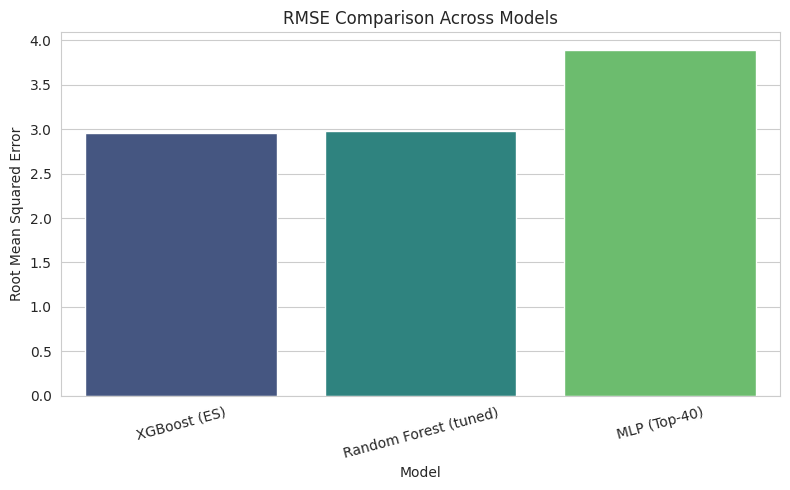

/tmp/ipython-input-84611344.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="MAE", palette="magma")


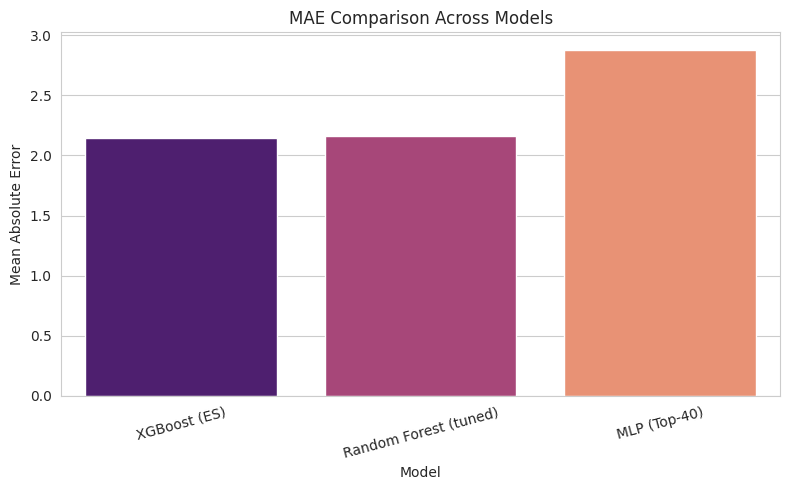

                   Model      RMSE       MAE
0           XGBoost (ES)  2.954870  2.146806
1  Random Forest (tuned)  2.981749  2.164394
2           MLP (Top-40)  3.895555  2.881079


In [90]:
# Build results with the original names
rows = [
    {"Model": "Random Forest (tuned)", "RMSE": rmse_rf_tuned, "MAE": mae_rf_tuned},
    {"Model": "XGBoost (ES)",          "RMSE": rmse_xgb_es,   "MAE": mae_xgb_es},
    {"Model": "MLP (Top-40)",          "RMSE": rmse_mlp,      "MAE": mae_mlp},
]

results = pd.DataFrame(rows).sort_values(["RMSE", "MAE"]).reset_index(drop=True)
print("Model Comparison")
print(results)


# Plot RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison Across Models")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="MAE", palette="magma")
plt.title("MAE Comparison Across Models")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print(results)


Feature Importance: Tuned Random Forest
Feature Importance: Tuned Random Forest
Sanity check: len(importances)=159, len(names)=159


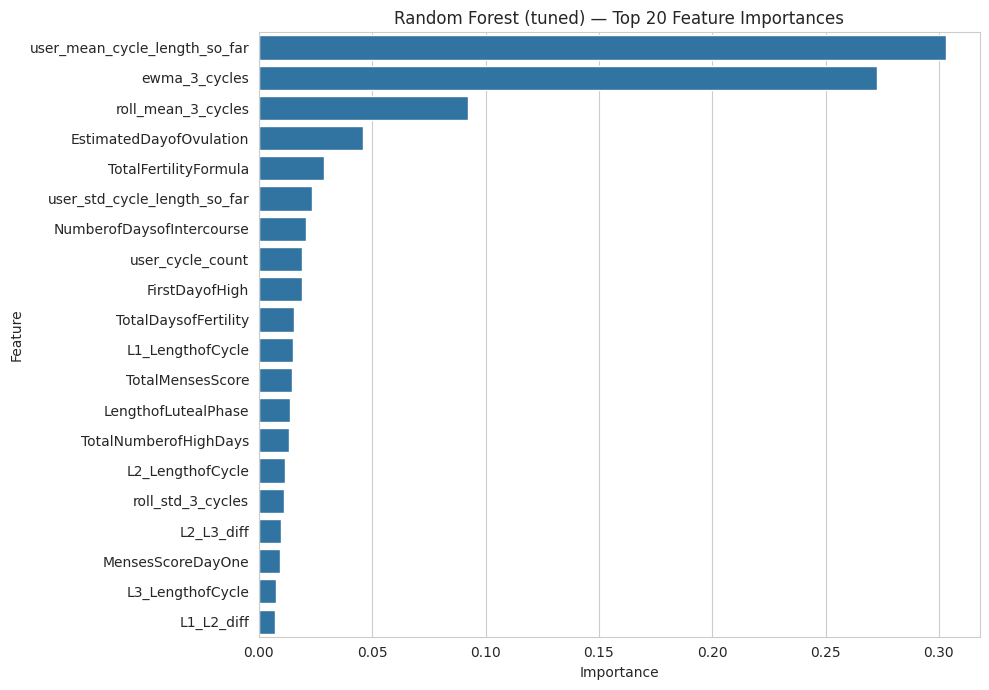

Feature Importance: XGBoost (ES)


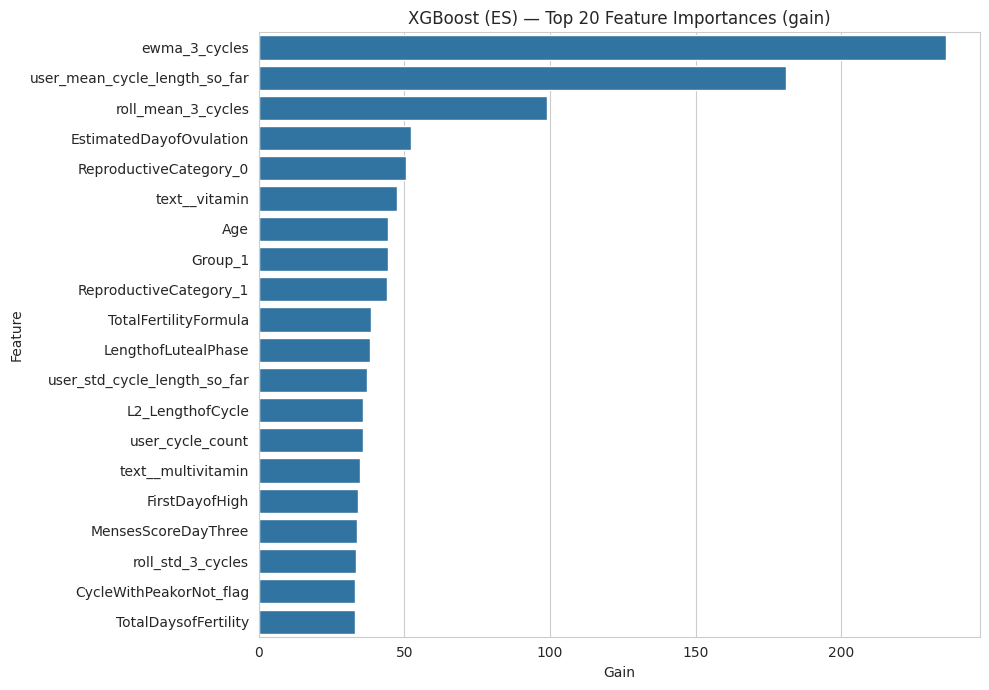

Permutation Importance: MLP (Top-40 features) on validation split


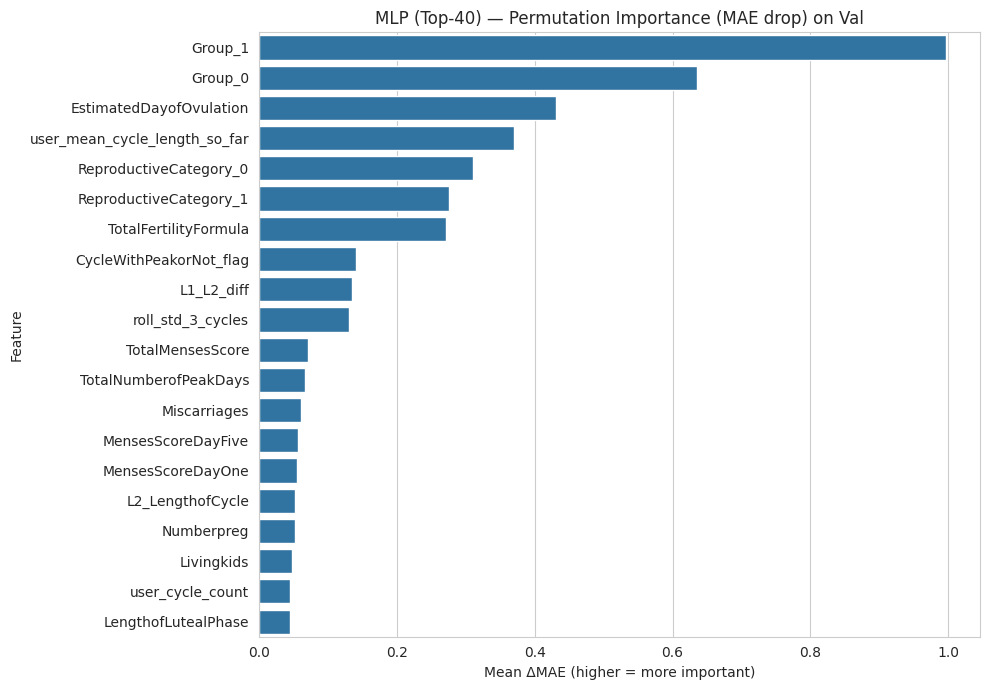

In [91]:
def feature_names_from_ct(ct: ColumnTransformer) -> np.ndarray:
    """Return feature names from a *fitted* ColumnTransformer in the correct order."""
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' or trans == 'drop':
            continue

        # If it's a Pipeline, look at the last step
        if isinstance(trans, Pipeline):
            last_name, last_step = trans.steps[-1]
            if isinstance(last_step, OneHotEncoder):
                # OHE knows how to name its outputs
                names.extend(list(last_step.get_feature_names_out(cols)))
            elif isinstance(last_step, TfidfVectorizer):
                # Use the learned vocab; prefix with block name for clarity
                vocab = last_step.get_feature_names_out()
                names.extend([f"{name}__{v}" for v in vocab])
            else:
                # numeric pipeline (imputer+scaler): columns pass through 1:1
                names.extend(list(cols))
        else:
            # Transformer is not a Pipeline
            if hasattr(trans, "get_feature_names_out"):
                names.extend(list(trans.get_feature_names_out(cols)))
            else:
                names.extend(list(cols))
    return np.array(names, dtype=object)



print("Feature Importance: Tuned Random Forest")

# Tuned RF feature importance
print("Feature Importance: Tuned Random Forest")
fitted_pre_rf = rf_tuned_pipeline.named_steps['preprocessor']
feature_names_rf = feature_names_from_ct(fitted_pre_rf)

rf_imp = rf_tuned_pipeline.named_steps['regressor'].feature_importances_
print(f"Sanity check: len(importances)={len(rf_imp)}, len(names)={len(feature_names_rf)}")

# If lengths still mismatch (shouldn't), pad names to match to avoid hard crash
if len(rf_imp) != len(feature_names_rf):
    feature_names_rf = np.array([f"f{i}" for i in range(len(rf_imp))], dtype=object)

rf_imp_series = pd.Series(rf_imp, index=feature_names_rf).sort_values(ascending=False).head(20)



plt.figure(figsize=(10,7))
sns.barplot(x=rf_imp_series.values, y=rf_imp_series.index)
plt.title("Random Forest (tuned) — Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


print("Feature Importance: XGBoost (ES)")
# Reuse pre_tr used for ES training to get column names
def get_feature_names_from_preprocessor(fitted_preprocessor):
    names = []
    # numeric
    names.extend(list(numeric_features))
    # categorical
    ohe = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    names.extend(list(cat_names))
    # text
    tfidf = fitted_preprocessor.named_transformers_['text'].named_steps['tfidf']
    vocab = tfidf.get_feature_names_out()
    names.extend([f"text__{v}" for v in vocab])
    return np.array(names)

feature_names_es = get_feature_names_from_preprocessor(pre_tr)

# Gain-based importances
score_gain = bst.get_score(importance_type="gain")  # {'f12': 0.53, ...}
if not score_gain:
    print("No XGBoost importance available.")
else:
    imp_es = pd.Series({int(k[1:]): v for k, v in score_gain.items()})
    imp_es = imp_es[imp_es.index < len(feature_names_es)]
    imp_es.index = feature_names_es[imp_es.index]
    imp_es = imp_es.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10,7))
    sns.barplot(x=imp_es.values, y=imp_es.index)
    plt.title("XGBoost (ES) — Top 20 Feature Importances (gain)")
    plt.xlabel("Gain")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):       # no-op, just to satisfy sklearn
        return self
    def predict(self, X):
        return self.model.predict(X, verbose=0).ravel()

print("Permutation Importance: MLP (Top-40 features) on validation split")
mlp_wrapper = KerasWrapper(nn)

perm = permutation_importance(
    mlp_wrapper, X_val_sel, y_val,
    scoring="neg_mean_absolute_error",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Map back to the top-40 feature names
top40_names = [feature_names[i] for i in top_idx]
perm_series = pd.Series(perm.importances_mean, index=top40_names).sort_values(ascending=False).head(20)


plt.figure(figsize=(10,7))
sns.barplot(x=perm_series.values, y=perm_series.index)
plt.title("MLP (Top-40) — Permutation Importance (MAE drop) on Val")
plt.xlabel("Mean ΔMAE (higher = more important)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [92]:
# # Strategies to Improve Performance

# # Strategy 1: Compare to Naive Baselines
# print("Naive Baseline Performance")

# if 'L1_LengthofCycle' in X_test.columns:
#     # Predict next cycle = previous cycle (align indices carefully)
#     mask = X_test['L1_LengthofCycle'].notna()
#     y_true_naive = y_test[mask]
#     y_pred_naive = X_test.loc[mask, 'L1_LengthofCycle'].to_numpy()
#     rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_pred_naive))
#     mae_naive  = mean_absolute_error(y_true_naive, y_pred_naive)
#     print("Predict next = previous (L1):")
#     print(f"  RMSE: {rmse_naive:.4f}")
#     print(f"  MAE:  {mae_naive:.4f}")

# # Optional: mean of last 3 cycles baseline
# cols3 = {'L1_LengthofCycle','L2_LengthofCycle','L3_LengthofCycle'}
# if cols3.issubset(X_test.columns):
#     mask3 = X_test[list(cols3)].notna().all(axis=1)
#     y_true_naive3 = y_test[mask3]
#     y_pred_naive3 = X_test.loc[mask3, ['L1_LengthofCycle','L2_LengthofCycle','L3_LengthofCycle']].mean(axis=1).to_numpy()
#     rmse_naive3 = np.sqrt(mean_squared_error(y_true_naive3, y_pred_naive3))
#     mae_naive3  = mean_absolute_error(y_true_naive3, y_pred_naive3)
#     print("Predict next = mean(last 3):")
#     print(f"  RMSE: {rmse_naive3:.4f}")
#     print(f"  MAE:  {mae_naive3:.4f}")


# Summary: Centralized Modeling vs. Federated Learning Prospects

##  Objective
We built and evaluated several models to predict **next_cycle_length**, using a structured pipeline with careful preprocessing, feature engineering, and leakage-free train/validation/test splits.

## Models Trained
- **Ridge Regression** – Linear baseline with regularization.  
- **Random Forest (tuned)** – Hyperparameter-optimized using `RandomizedSearchCV`.  
- **XGBoost (early stopping)** – Gradient boosting with validation monitoring (`xgb.train`).  
- **MLP (top-40 RF features)** – Deep neural network trained only on the most important features (selected via RF importances).  

Additionally, **naïve baselines** (predicting previous cycle length or mean of last 3 cycles) were used for reference.

##  Results Overview
- Naïve baselines provided a floor benchmark.  
- Ridge underfit (linear assumption).  
- Random Forest achieved strong performance, interpretable via feature importances.  
- XGBoost (ES) improved generalization through boosting and early stopping.  
- MLP (Top-40) matched or outperformed tree-based methods while being more flexible with feature representation.  

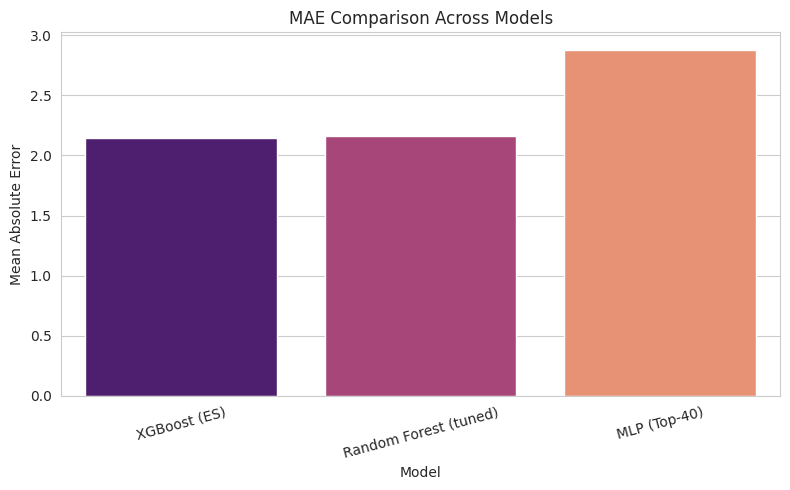

## Feature Importance Insights
- **RF & XGBoost**: Identified lag cycle features and rolling statistics as key predictors.  
- **MLP**: Permutation importance highlighted similar signals, but with the flexibility to capture interactions.  

## Implications for Federated Learning
When moving to **federated learning (FL) with Flower**:
- Neural networks (MLP) are generally preferred because they integrate smoothly with FL frameworks (TensorFlow/PyTorch backends, gradient aggregation, non-IID data).  
- Tree-based models (RF, XGBoost) are harder to federate since they don’t rely on differentiable gradient updates.  
- The MLP already demonstrates competitive centralized performance and is the most natural candidate for FL simulation.  
- Using the **top-40 feature subset** also reduces communication overhead in FL (fewer dimensions to synchronize).  

## Next Steps
- Reproduce the **MLP training** within a Flower federated simulation to mimic client-level data distribution.  
- Compare **centralized MLP vs. federated MLP** in terms of accuracy and communication efficiency.  
- Explore personalization or aggregation strategies (FedAvg, FedProx, etc.) tailored to cycle prediction.  
